In [430]:
import argparse
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import pandas as pd

from dataset import get_dataloader
from tqdm import tqdm
import random
from models.gated_tpp import *
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

def triggering_kernel(t,n_kernel = 0):
    
    if n_kernel ==0:
        return 0.2*(0.5+t)**(-1.3)
    elif n_kernel ==1:
        return 0.03*np.exp(-0.3*t)
    elif n_kernel ==2:
        return 0.05*np.exp(-0.2*t) + 0.16*np.exp(-0.8*t)
    else:
        t_c = np.copy(t)
        t_c[t_c>4] =0
        sin = np.sin(t_c)/8
        sin[sin <0] =0
        return sin

def magic_kernel(x, sigma=1, lengthscale=5, alpha=1):
    d= x
    k1 = (1 + torch.exp(-d))**(-alpha*2)
    k2 = torch.exp(-(d) / lengthscale)
    scores = (sigma)*(k1)*(k2)

    return scores   


In [407]:
params = pd.read_csv('learned_params_2.csv')
params.tail(12)

,Model_ID,L11,L21,L12,L22,Sigma 11,Sigma 21,Sigma 12,Sigma 21.1,Lengthscale11,Lengthscale12,Lengthscale21,Lengthscale22,s11,s12,s21,s22,beta_1,beta_2,beta_3
100,5653475d16,0.678160,0.853990,0.346419,0.447404,0.867592,0.692788,0.206779,0.156067,1.754000,2.253785,4.001850,4.572684,0.6,1.0,0.8,NaN,NaN,NaN,NaN
101,4e65042348,0.873733,0.887812,0.388544,0.395734,0.685987,0.867042,0.158390,0.212118,1.789957,2.584188,1.187582,1.886638,0.6,1.0,0.8,NaN,NaN,NaN,NaN
102,8cd9089138,0.697244,0.857951,0.323782,0.408714,0.991067,0.839949,0.321705,0.262708,1.845721,2.356570,4.285447,4.862525,0.6,1.0,0.7,NaN,NaN,NaN,NaN
103,b736746157,0.678160,0.853990,0.346419,0.447404,0.867592,0.692788,0.206779,0.156067,1.754000,2.253785,4.001850,4.572684,0.6,1.0,0.8,NaN,NaN,NaN,NaN
104,797173fe30,0.737682,0.879162,0.301235,0.368140,1.156247,1.074849,0.527631,0.483974,1.943473,2.458224,4.570397,5.145666,0.6,1.0,0.6,NaN,NaN,NaN,NaN
105,711bcf9746,0.685516,0.881690,0.360284,0.476176,0.790061,0.555172,0.166181,0.109062,1.753490,2.156637,3.846395,4.308676,0.6,1.0,0.7,NaN,NaN,NaN,NaN
106,60468ff514,0.666146,0.862110,0.386061,0.511707,0.521843,0.362078,0.107848,0.070985,1.702722,2.120452,3.563339,4.043324,0.6,1.0,0.8,NaN,NaN,NaN,NaN
107,1a7fe4a50c,0.700572,0.888643,0.333006,0.434897,1.142056,0.823481,0.272970,0.182226,1.853159,2.238843,4.169755,4.607668,0.6,1.0,0.6,NaN,NaN,NaN,NaN
108,641dc35bad,0.685516,0.881690,0.360284,0.476176,0.790061,0.555172,0.166181,0.109062,1.753490,2.156637,3.846395,4.308676,0.6,1.0,0.7,NaN,NaN,NaN,NaN
109,e7fbcb7633,0.666146,0.862110,0.386061,0.511707,0.521843,0.362078,0.107848,0.070985,1.702722,2.120452,3.563339,4.043324,0.6,1.0,0.8,NaN,NaN,NaN,NaN


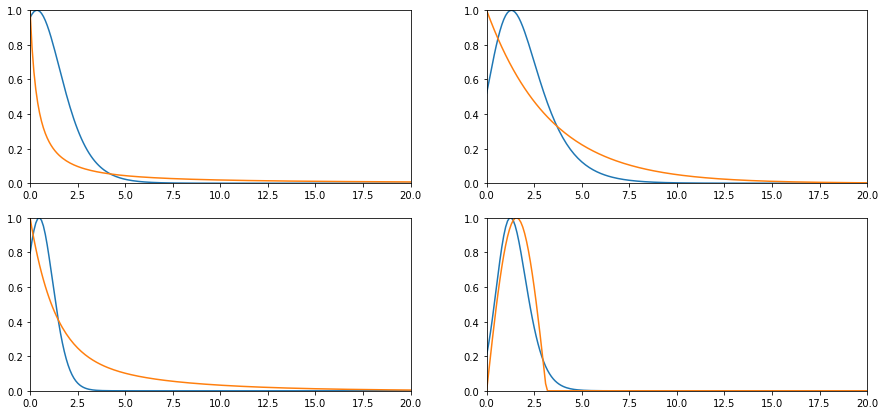

In [417]:
model_id  = 'ef202e83f8'
lengtscales = params.loc[params.Model_ID ==model_id].values[0][1:5]
sigmas = params.loc[params.Model_ID ==model_id].values[0][5:9]
alphas = params.loc[params.Model_ID ==model_id].values[0][9:13]
# ss = params.loc[params.Model_ID ==model_id].values[0][13:17]

t =torch.arange(0,200,0.1)+0.000001


fig, axes = plt.subplots(2, 2,figsize=(15,7))
axes = axes.flatten()
for i in range(len(axes)):

    values = magic_kernel(t,sigma = sigmas[i], lengthscale = lengtscales[i], alpha = alphas[i])
    values = (values - values.min())/(values.max()-values.min())
    real_values = triggering_kernel(t,i)
    real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

    axes[i].plot(t,values)
    axes[i].plot(t,real_values)
    axes[i].set_xlim(0, 20)
    axes[i].set_ylim(0, 1)       
# axes[0].set_xlim(0, 10)
# axes[1].set_ylim(0, 0.2)
# axes[2].set_xlim(0, 10)
# axes[3].set_ylim(0, 0.3)


## Interaction of Kernels

In [175]:
def magic_kernel_2(x, sigma=1, lengthscale=1, alpha=1,p = 1):
    d= x
    k1 = (1 + torch.exp(p-d))**(-alpha)
    a = 1
    k2 = k2 =  (1 + (d ** 2) / (a * lengthscale ** 2)) ** (-a)
    scores = (sigma)*(k1)*(k2)

    return k2,k1,scores


(0.0, 20.0)

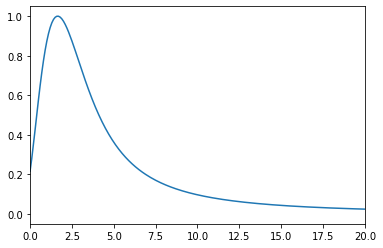

In [176]:
time = torch.arange(1,20,0.1)
values = magic_kernel_2(t,sigma = 1,lengthscale =1.0,alpha  =5.5,p=0)[-1]
values = (values - values.min())/(values.max()-values.min())
plt.plot(t,values)
plt.xlim(0,20)

Text(0.5, 1.0, 'Interaction')

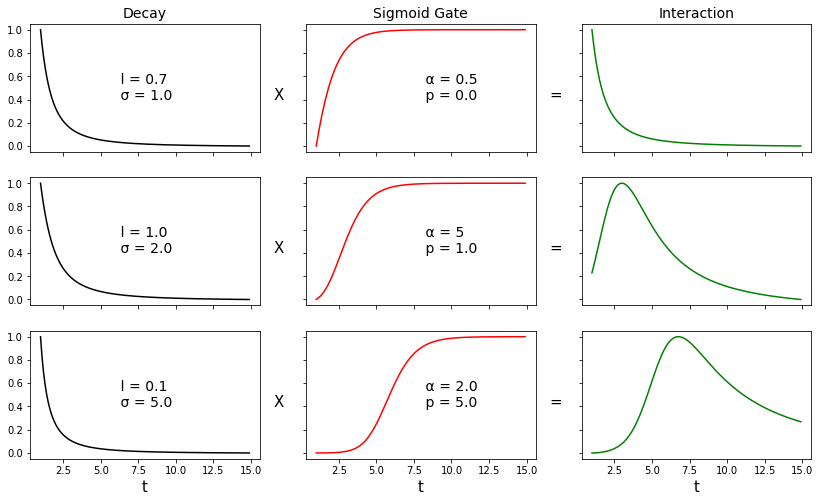

In [220]:
lengtscales = [0.7,1.0,0.1]
alphas = [0.5,5,2.0]
ps = [0.0,1.0,5.0]
sigmas = [1.0,2.0,5.0]


fig, axes = plt.subplots(3, 3,figsize=(14,8),sharex=True,sharey=True)
time = torch.arange(1,15,0.1)

for i in range(3):    
    decay,gate,values = magic_kernel_2(time,sigma = sigmas[i],lengthscale =lengtscales[i],alpha  =alphas[i],p = ps[i])
    decay = (decay - decay.min())/(decay.max()-decay.min())
    gate = (gate - gate.min())/(gate.max()-gate.min())      
    values = (values - values.min())/(values.max()-values.min())
    axes[i][0].plot(time,decay,c = 'black')
    axes[i][1].plot(time,gate,c='red')
    axes[i][2].plot(time,values,c='green')
    axes[i][0].text(6,0.4,f' l = {lengtscales[i]}\n \u03C3 = {sigmas[i]}',size = 14 )
    axes[i][0].text(16.5,0.4,f'X',size = 15 )
    axes[i][1].text(16.5,0.4,f'=',size = 15 )
    axes[i][1].text(8,0.4,f' \u03B1 = {alphas[i]}\n p = {ps[i]}',size = 14 )
for j in range(3):
    axes[2][j].set_xlabel('t',size = 15)
    
axes[0][0].set_title('Decay',size = 14)
axes[0][1].set_title('Sigmoid Gate',size = 14)
axes[0][2].set_title('Interaction',size = 14)

## Plotting the Triggering Kernels

In [225]:
sahp_kernel = np.load('sahp_kernels.npy',allow_pickle=True)
thp_kernel = np.load('thp_kernels.npy',allow_pickle=True)
lognorm_kernel = np.load('attention_lognormal_kernel.npy',allow_pickle=True)

In [253]:
sahp_kernel.item()['times']

[array([ 0.        ,  0.09143162,  2.1524487 , ..., 34.783432  ,
        26.620178  ,  0.        ], dtype=float32),
 array([ 6.0995436,  6.190975 ,  8.251992 , ..., 30.771942 , 22.608688 ,
         4.01149  ], dtype=float32),
 array([6.0995436, 2.1724777, 0.3409567, ..., 5.819336 , 5.0387726,
        4.01149  ], dtype=float32),
 array([0.       , 3.9270658, 5.758587 , ..., 1.8078461, 1.0272827,
        0.       ], dtype=float32)]

In [390]:
all_results=[[],[],[]]
all_times=[[],[],[]]

for i in range (4):  
    

    k_val = lognorm_kernel.item()['scores'][i]
    t_val =  lognorm_kernel.item()['times'][i]*200
    sorted_index = np.argsort(t_val)
    t = t_val[sorted_index]
    k = k_val[sorted_index]

#     moving_average = 10000

#     ## Moving Average 
#     k = np.convolve(k, np.ones(moving_average), 'valid') / moving_average    
#     t = np.convolve(t, np.ones(moving_average), 'valid') / moving_average
    small_t,small_k = moving_average(t,k,step = 0.5)
    all_results[-1].append(np.array(small_k))
    all_times[-1].append(np.array(small_t))
    

    

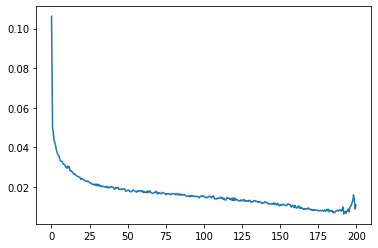

In [386]:
plt.plot( all_times[-1][0],all_results[-1][0])

In [391]:
for i in range (4):  
    

    k_val = sahp_kernel.item()['scores'][i]
    t_val =  sahp_kernel.item()['times'][i]
    sorted_index = np.argsort(t_val)
    t = t_val[sorted_index]
    k = k_val[sorted_index]

#     moving_average = 10000

#     ## Moving Average 
#     k = np.convolve(k, np.ones(moving_average), 'valid') / moving_average    
#     t = np.convolve(t, np.ones(moving_average), 'valid') / moving_average
    small_t,small_k = moving_average(t,k,step = 0.5)
    all_results[-2].append(np.array(small_k))
    all_times[-2].append(np.array(small_t))
    

In [392]:
for i in range (4):  
    

    k_val = thp_kernel.item()['scores'][i]
    t_val =  thp_kernel.item()['times'][i]
    sorted_index = np.argsort(t_val)
    t = t_val[sorted_index]
    k = k_val[sorted_index]

#     moving_average = 10000

#     ## Moving Average 
#     k = np.convolve(k, np.ones(moving_average), 'valid') / moving_average    
#     t = np.convolve(t, np.ones(moving_average), 'valid') / moving_average
    
    small_t,small_k = moving_average(t,k,step = 0.5)
    all_results[-3].append(np.array(small_k))
    all_times[-3].append(np.array(small_t))

In [382]:
def moving_average(t,k,step = 0.5):


    small_t = []
    small_k =[]
    step = 0.5
    num_index = int(200//step)
    low = 0
    for i in range(num_index):

        mask = ((t>=low) *(t<low+step))
        cur_k = k[mask].mean()
        cur_t = t[mask].mean()
        small_t.append(cur_t)
        small_k.append(cur_k)
        low +=step
    return small_t,small_k

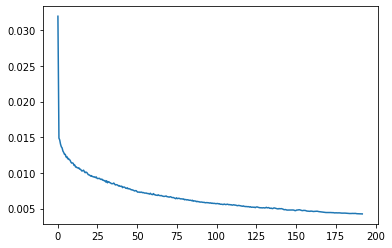

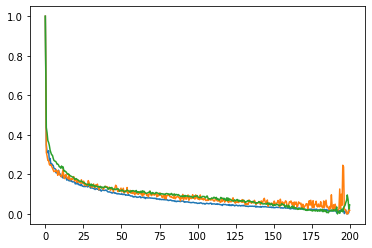

In [393]:
# k_val = thp_kernel.item()['scores'][i]
# t_val =  thp_kernel.item()['times'][i]
# sorted_index = np.argsort(t_val)
# t = t_val[sorted_index]
# k = k_val[sorted_index]

# moving_average = 10000

# ## Moving Average 
# k_thp = np.convolve(k, np.ones(moving_average), 'valid') / moving_average    
# t_thp = np.convolve(t, np.ones(moving_average), 'valid') / moving_average

kernel = 0
for i in range(3):
    times =all_times[i][kernel]
    kernels = all_results[i][kernel]
    kernels = (kernels - kernels.min())/(kernels.max()-kernels.min())

    plt.plot(times,kernels)


# plt.plot(t_thp,k_thp)
# plt.plot(t_thp,k_thp)
# plt.plot(t_thp,k_thp)

In [308]:
i = 2
plot_times = torch.arange(0,20,0.1)
values = magic_kernel(plot_times,sigma = sigmas[i], lengthscale = lengtscales[i], alpha = alphas[i])
values = (values - values.min())/(values.max()-values.min())

real_values = triggering_kernel(plot_times,i)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

k = (k - k.min())/(k.max()-k.min())


Text(0, 0.5, '$\\mathregular{\\phi_{22}}$')

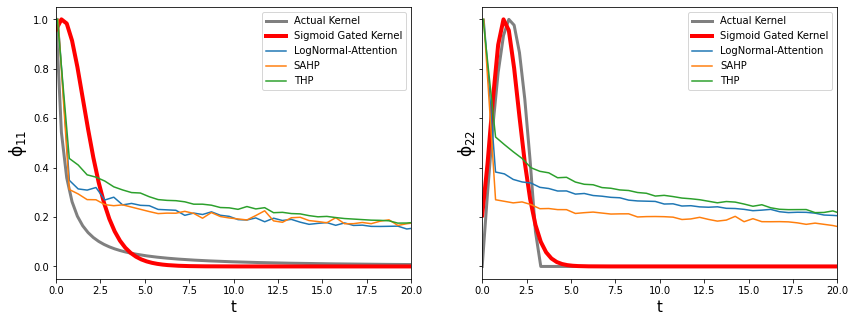

In [449]:
fig, axes = plt.subplots(1, 2,figsize=(14,5),sharex=False,sharey=True)
axes = axes.flatten()
plot_times = torch.arange(0,200,0.3)
names = ['LogNormal-Attention','SAHP','THP']
plot_index = 0
for i in range(len(axes)):
    
    
    values = magic_kernel(plot_times,sigma = sigmas[plot_index], lengthscale = lengtscales[plot_index], alpha = alphas[plot_index])
    values = (values - values.min())/(values.max()-values.min())

    real_values = triggering_kernel(plot_times,plot_index)
    real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())
    
    axes[i].plot(plot_times,real_values,linewidth=3,c ='gray',label ='Actual Kernel')
    axes[i].plot(plot_times,values,linewidth=4,c ='red',label ='Sigmoid Gated Kernel')
    axes[i].set_xlabel('t',size = 15)
    

    for j in range(3):
        times =all_times[j][plot_index]
        kernels = all_results[j][plot_index]
        kernels = (kernels - kernels.min())/(kernels.max()-kernels.min())
        axes[i].plot(times,kernels,label = names[j])
        axes[i].set_xlim(0,20)

    plot_index+=3
for ax in axes:
    ax.legend()

axes[0].set_ylabel('$\mathregular{\phi_{11}}$',size = 17)
axes[1].set_ylabel('$\mathregular{\phi_{22}}$',size = 17)

In [355]:
len(all_times[j][i])

1367882

In [293]:
i = 1
plot_times = torch.arange(0,15,0.1)
values = magic_kernel(plot_times,sigma = sigmas[i], lengthscale = lengtscales[i], alpha = alphas[i])
values = (values - values.min())/(values.max()-values.min())

real_values = triggering_kernel(plot_times,i)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

k = (k - k.min())/(k.max()-k.min())
